In [1]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from vital_raw import *
print("using device: ", device)


Random seed set to 333
using device:  cpu


## Customize Configuration

In [3]:
# (customize) configs
overwrite = True
model_name = 'testtest'
text_config['cl']['die7d'] = True # udpate text_config here if needed
text_config['split'] = True
text_config['demo']['gre'] = True
text_config['demo']['apgar_mage'] = True
model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    model_name = model_name,
    ts_aug = True, # Data settings
    ts_subseq = False,
    ts_augsub = False,
    downsample = True,
    downsample_size = 1000,
    balance = True,
    block_target = True,
    embedded_dim = 32,
    batch_size = 2048, # Data loader settings
    ts_global_normalize = False,
    ts_local_normalize = False,# True,
    patience = 20, # Training settings
    num_saves = 20,
    num_epochs = 10000,
    init_lr = 1e-4,
    text_config = text_config,
    text_col_ls = ['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother']
)
config_dict = get_config_dict()

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.0s
[Parallel(n_jobs=9)]: Done 2596 tasks      | elapsed:    4.5s
[Parallel(n_jobs=9)]: Done 62812 tasks      | elapsed:   10.6s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   10.8s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams. This infant is Female Black non-Hispanic. The Apgar5 scores 6. Mother is 21 years old.    Moderate variability.  Very low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    1.7s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    6.2s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    6.2s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams. This infant is Male non-Black non-Hispanic. The Apgar5 scores 9. Mother is 26 years old.    High variability.  Low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']
After downsampling:
cl_event
This infant will survive.           1000
This infant will die in 7 days.      384
Name: count, dtype: int64
After downsampling:
cl_event
This infant will survive.           1000
This infant will die in 7 days.      241
Name: count, dtype: int64
Original class distribution:
Class This infant will die in 7 days. : 384
Class This infant will survive. : 1000

Target size per class: 1000
Total cores available: 12
Using 9 cores for parallel processing


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.


Random seed set to 333
Random seed set to 333
Random seed set to 333Random seed set to 333Random seed set to 333


Random seed set to 333
Random seed set to 333
Random seed set to 333
Random seed set to 333


[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    1.5s
[Parallel(n_jobs=9)]: Done 384 out of 384 | elapsed:    2.4s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=9)]: Done 692 tasks      | elapsed:    2.5s
[Parallel(n_jobs=9)]: Done 768 out of 768 | elapsed:    2.9s finished


This infant will die in 7 days.  This infant has gestational age 24 weeks. Birth weight is 400 grams. This infant is Male non-Black non-Hispanic. The Apgar5 scores 2. Mother is 29 years old.    Moderate variability.  Low amount of consecutive increases. 

Available text columns:
['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_gender', 'demo_race', 'demo_ethnicity', 'demo_apgar', 'demo_mother', 'cl_die7d']
Augmented 1536 rows

Final class distribution:
Class This infant will die in 7 days. : 1000
Class This infant will survive. : 1000


/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will survive.           1000
This infant will die in 7 days.     1000
Name: count, dtype: int64
cl_event
This infant will survive.           1000
This infant will die in 7 days.      241
Name: count, dtype: int64


## Customize VITAL Model

In [5]:
# # for testing purposes
# %load_ext autoreload
# %autoreload 1
# %aimport vital_raw

In [6]:
# customize model
if overwrite:    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], 
                                                                config_dict['text_encoder_name'], 
                                                                config_dict['ts_normalize_mean'],
                                                                config_dict['ts_normalize_std'],
                                                                text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], 
                                                            config_dict['text_encoder_name'], 
                                                            config_dict['ts_normalize_mean'],
                                                            config_dict['ts_normalize_std'])
    
    ts_encoder = None
    ts_decoder = None
    # #--- custom ts encoder in encoder.py ---
    # e = MLPEncoder(
    #     ts_dim=ts_f_dim.shape[1], 
    #     output_dim=config_dict['embedded_dim']
    # )
    # ts_encoder = TSVAEEncoderWrapper(e)
    # # --- custom ts decoder in decoder.py ---
    # d = MLPDecoder(
    #     ts_dim=ts_f_dim.shape[1], 
    #     output_dim=config_dict['embedded_dim']
    # )
    # ts_decoder = TSVAEDecoderWrapper(d)

    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    # ------------------------- ready training -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config_dict['init_lr'],
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=config_dict['patience'],       
        verbose=True,
        min_lr=1e-10,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=1.0, 
                             end=1.0, 
                             epochs=10000) # for the first 1000 epochs, favor reconstruction more


    train_eval_metrics_list = []
    test_eval_metrics_list = []
    train_losses = []
    test_losses = []

    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    # torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
   

Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoder: 1-1                                                    --
│    └─LocalNorm: 2-1                                                  --
│    └─Sequential: 2-2                                                 --
│    │    └─Linear: 3-1                                                77,056
│    │    └─LeakyReLU: 3-2                                             --
│    │    └─Linear: 3-3                                                131,584
│    │    └─LeakyReLU: 3-4                                             --
│    │    └─Linear: 3-5                                                262,656
│    │    └─LeakyReLU: 3-6                                             --
│    │    └─Linear: 3-7                                                262,656
│    │    └─LeakyReLU: 3-8                                             --
│    │    └─Lin

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Test CLIP

In [ ]:
for i in range(100):  # n_evals
    train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                    train_dataloader,
                                                    test_dataloader, 
                                                    optimizer, 
                                                    scheduler,
                                                    kl_annealer,
                                                    num_epochs=10, 
                                                    train_type='clip')
    train_losses = train_losses + train_losses_tmp
    test_losses = test_losses + test_losses_tmp
    # every num_epochs, evaluate the model
    model.eval()
    if config_dict['3d']:
        train_eval_metrics = eval_clip3d(model, evalinputs_train)
        test_eval_metrics = eval_clip3d(model, evalinputs_test)
    else:
        train_eval_metrics = eval_clip(model, evalinputs_train)
        test_eval_metrics = eval_clip(model, evalinputs_test)
    train_eval_metrics_list.append(train_eval_metrics)
    test_eval_metrics_list.append(test_eval_metrics)
    eval_dict= {'train_losses': train_losses,
                'test_losses': test_losses,
                'train_evals': train_eval_metrics_list,
                'test_evals': test_eval_metrics_list }
    eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot=False)
    print("-" * 70)
    print(f"Metric     |  Training  |  Testing")
    print("-" * 70)
    print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
    print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
    print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
    print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
    print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
    print("-" * 70)


beta: 1.0
Epoch [1/10]
	Training Loss: 70.416557
	Testing Loss: 19.395973
	Learning Rate: 0.000100000
beta: 1.0
Epoch [2/10]
	Training Loss: 50.179317
	Testing Loss: 17.589920
	Learning Rate: 0.000100000
beta: 1.0
Epoch [3/10]
	Training Loss: 46.228996
	Testing Loss: 15.127360
	Learning Rate: 0.000100000
beta: 1.0
Epoch [4/10]
	Training Loss: 42.029648
	Testing Loss: 14.132858
	Learning Rate: 0.000100000
beta: 1.0
Epoch [5/10]
	Training Loss: 41.182335
	Testing Loss: 15.055726
	Learning Rate: 0.000100000
beta: 1.0
Epoch [6/10]
	Training Loss: 40.662868
	Testing Loss: 15.332062
	Learning Rate: 0.000100000
beta: 1.0
Epoch [7/10]
	Training Loss: 36.316383
	Testing Loss: 13.096587
	Learning Rate: 0.000100000
beta: 1.0
Epoch [8/10]
	Training Loss: 33.890270
	Testing Loss: 12.038313
	Learning Rate: 0.000100000
beta: 1.0
Epoch [9/10]
	Training Loss: 31.313530
	Testing Loss: 11.349629
	Learning Rate: 0.000100000
beta: 1.0
Epoch [10/10]
	Training Loss: 30.206364
	Testing Loss: 10.770288
	Learni

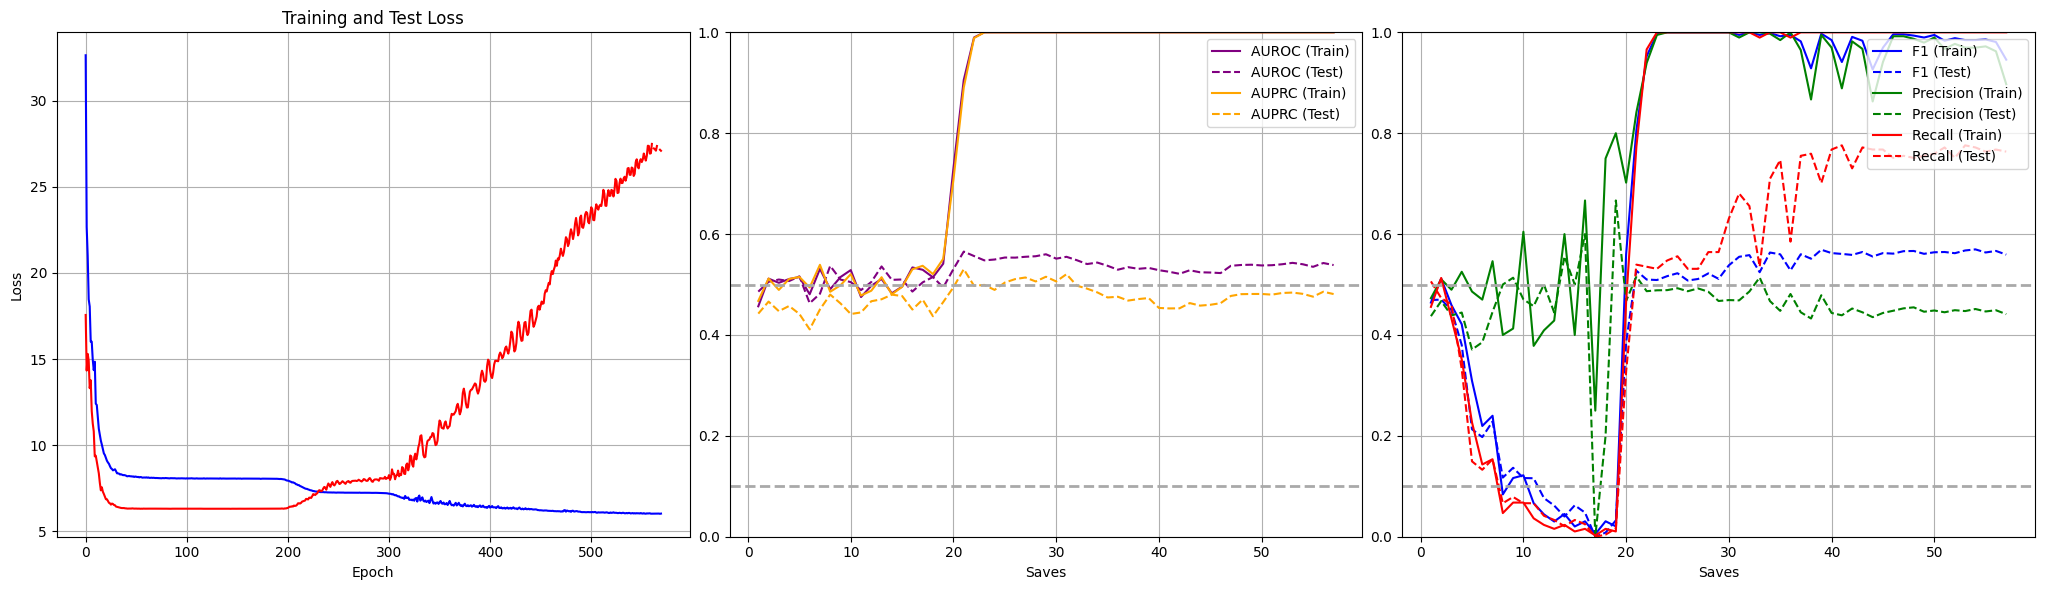

In [7]:
eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot=True)

# change attention to 256
# init_lr = 1e-5